# Diffusion

We have a diffusion equations of the form

$
    \partial_t \varphi(x, t) = D \nabla^2 \varphi(x, t) + \nabla \cdot [ \vec f(x) \varphi(x, t)  ] ,
$

Where $\vec f = - \nabla V$ is a force due to an external potential.

In [12]:
using Plots
using Random
using FFTW
using LinearAlgebra: mul!


L = 100
N = 1024
M = 1000
dt = 1e-1
dx = L / N
dk = 2π / L

x = (0:N-1) * dx
k = rfftfreq(N , N * dk)

k² = k.*k
ik = im.*k

D = .1
T = .01

F = plan_rfft(x)
B = plan_irfft(F*x, N)

V = @. cos(dk * x) / 10.
FV = F*V
f = - (B*(ik.*FV))


# function antialiasing!( F )
#     F[(end-(N÷2)÷3)+1:end] .= 0.
# end

# function etd!(Fφ, φ)
#     Fφ .= k1 .* Fφ 
#     # Fφ .+= - (k2 .* ik .* (F*(v.*φ)))
#     φ .= B*Fφ
#     antialiasing!(Fφ)
# end


NOISE = @. ik * sqrt(2 * D * T * (2 * pi / dk) * dt )

c = - D * k²
k1 = @. exp(c * dt)
k2 = @. (k1 - 1.) / c
k2[1] = 0

F = plan_rfft(x)
B = plan_irfft(F*x, N);


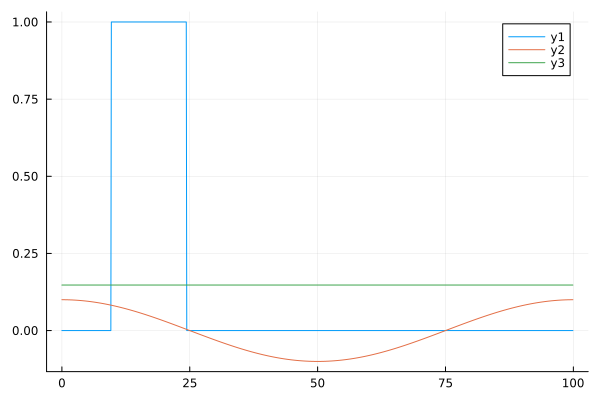

In [13]:
φ = zeros(N)
φ[100:250] .= 1.
Fφ = F*φ


plot(x, φ)
plot!(x, V)
plot!(x, sum(φ)/N .* ones(N))

In [14]:
# The linear par does not need to be leav Foureirspace
# We therefore only have Flin
nonlin = zero(φ)
Flin, Fnonlin = zero(Fφ), zero(Fφ)
sup = (nonlin=nonlin, Flin=Flin, Fnonlin=Fnonlin)
noise = zero(Fφ)


function UpdateLin!(Fφ, Flin)
    @. Flin = Fφ
end

function UpdateNonLin!(φ, Fφ, nonlin, Fnonlin)
    @. nonlin = φ * f
    mul!(Fnonlin, F, nonlin)
    @. Fnonlin = - ik * Fnonlin
end

function Noise!(Flin, noise)
    randn!(noise) 
    @. Flin += NOISE * noise
end

function antialiasing!( F )
    F[(end-(N÷2)÷3)+1:end] .= 0.
end

function etd!(Fφ, φ, sup)
    UpdateLin!(Fφ, sup.Flin)
    Noise!(sup.Flin, noise)
    UpdateNonLin!(φ, Fφ, sup.nonlin, sup.Fnonlin)
    antialiasing!(sup.Fnonlin)
    @. Fφ = k1 * Flin + k2 * sup.Fnonlin
    mul!(φ, B, Fφ)
end


etd! (generic function with 2 methods)

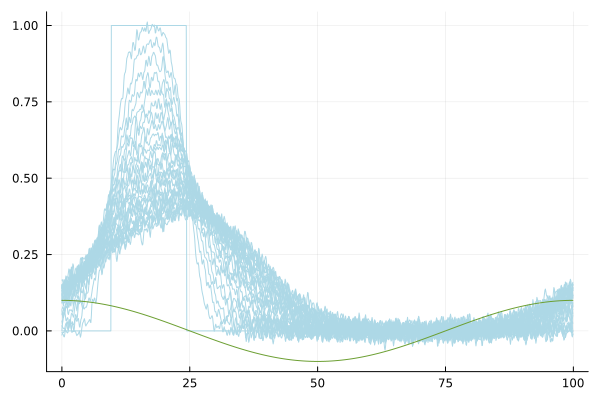

In [15]:
M = 10000
K = 30
p = plot(x, φ, color="lightblue")
av = sum(φ)/N
for t in 1:M
    etd!(Fφ, φ, sup)
    if t%(M÷K) == 0
        @assert abs(av - sum(φ)/N) < 1e-15
        @assert !any(isnan.(Fφ))
        plot!(x, φ; color="lightblue")
    end
end

plot!(legend=false)
plot!(x, V)
display(p)

In [67]:
N

1024

In [ ]:
1e-5 + 1e-18 ≈ 1e-5 